In [1]:
import os
import numpy as np

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchsummary import summary
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [22]:
trainset = datasets.FashionMNIST(root='./.data/fmnist',
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=0)

In [23]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [24]:
model = Autoencoder().to(DEVICE)
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 12]             780
              ReLU-6                [-1, 1, 12]               0
            Linear-7                 [-1, 1, 3]              39
            Linear-8                [-1, 1, 12]              48
              ReLU-9                [-1, 1, 12]               0
           Linear-10                [-1, 1, 64]             832
             ReLU-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             ReLU-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [25]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(
    autoencoder.parameters(),
    lr=0.005,
)
criterion = nn.MSELoss()

In [26]:
view_data = trainset.data[:5].view(-1, 28 * 28)
view_data = view_data.type(torch.FloatTensor) / 255.

In [27]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28 * 28).to(DEVICE)
        y = x.view(-1, 28 * 28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


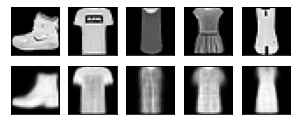

[Epoch 2]


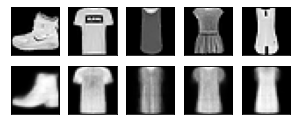

[Epoch 3]


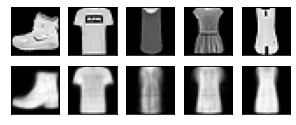

[Epoch 4]


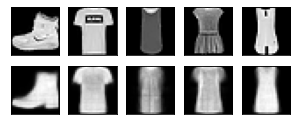

[Epoch 5]


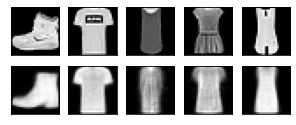

[Epoch 6]


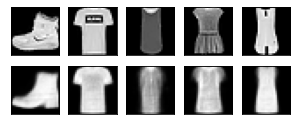

[Epoch 7]


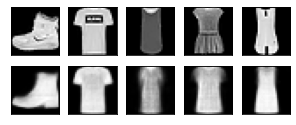

[Epoch 8]


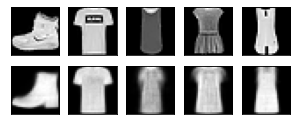

[Epoch 9]


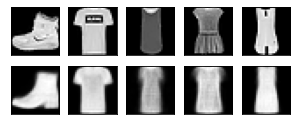

[Epoch 10]


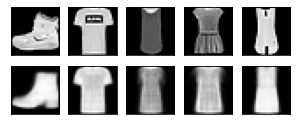

In [29]:
for epoch in range(1, EPOCH + 1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],
                         (28, 28))  #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()